# Generate some data

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import make_blobs

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, b0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                 cluster_std=blob_std, random_state=7)

In [21]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="jet", s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

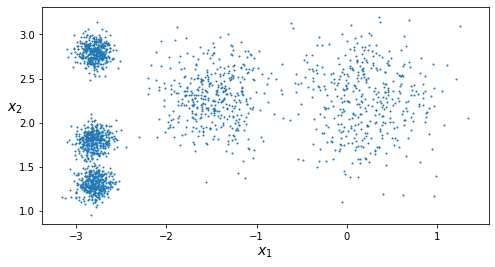

In [23]:
plt.figure(figsize=(8,4))
plot_clusters(X)
plt.show()

# KMeans

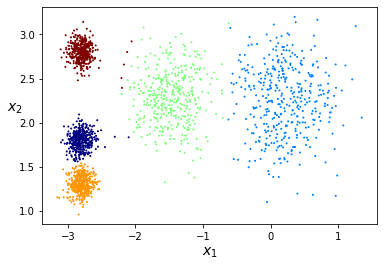

In [30]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
y_pred = kmeans.fit_predict(X)
plot_clusters(X, y_pred)


In [53]:
print(kmeans.cluster_centers_)
print(kmeans.inertia_)

[[-2.79145317  2.79524549]
 [-1.46492897  2.28575851]
 [ 0.20876306  2.25551336]
 [-2.80214068  1.55162671]]
261.7995628940648


### Lets look at decision boundries -- this is called a Voronoi Diagram

In [44]:
# The following code was copied and pasted from https://github.com/ageron/handson-ml/blob/master/08_dimensionality_reduction.ipynb

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=30, linewidths=2,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

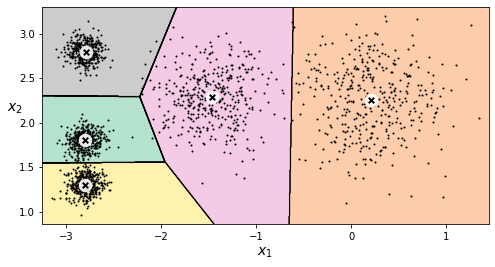

In [45]:
plt.figure(figsize=(8,4))
plot_decision_boundaries(kmeans, X)
plt.show()

### What if we don't pick the proper value of clusters?

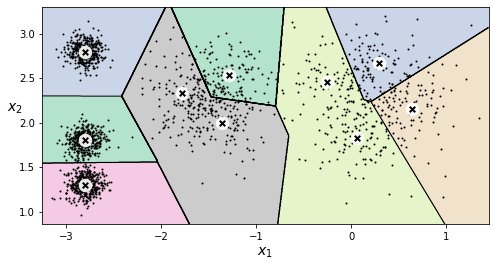

In [47]:
kmeans = KMeans(n_clusters=10)
y_pred = kmeans.fit_predict(X)
plt.figure(figsize=(8,4))
plot_decision_boundaries(kmeans, X)
plt.show()

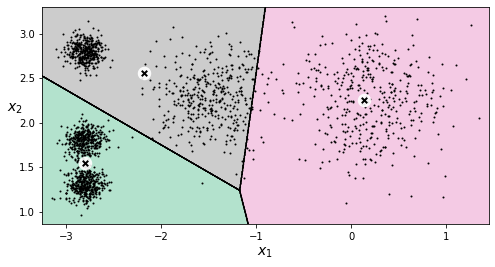

In [50]:
kmeans = KMeans(n_clusters=3)
y_pred = kmeans.fit_predict(X)
plt.figure(figsize=(8,4))
plot_decision_boundaries(kmeans, X)
plt.show()

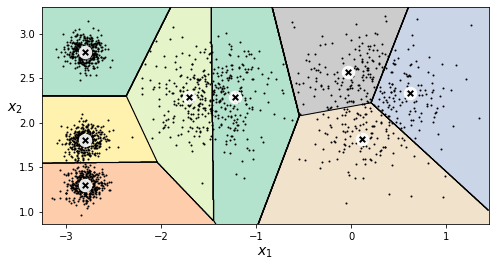

In [51]:
kmeans = KMeans(n_clusters=8)
y_pred = kmeans.fit_predict(X)
plt.figure(figsize=(8,4))
plot_decision_boundaries(kmeans, X)
plt.show()

# How to determine number of clusters?

#### Inertia is good for comparing across the same number of clusters. Lower interia will likely be a better fit. However, when choosing across multiple clusters, inertia is not the most reliable, as more clusters will have smaller inertia. However, there may be an elbow in the plot, which can give some intuition. Lets take a look

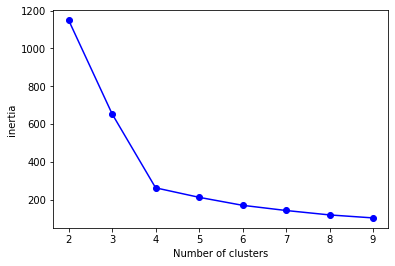

In [65]:
inertias = []
num_clusters = range(2, 10) 
for i in num_clusters:
    cur_kmeans = KMeans(n_clusters=i)
    cur_kmeans.fit(X)
    inertias.append(cur_kmeans.inertia_)
    
plt.plot(num_clusters, inertias, "bo-")
plt.xlabel("Number of clusters")
plt.ylabel("inertia")
plt.show()

#### Here we see an elbow at 4. Although thats not the best value, it still will produce a good clustering, lets take a look

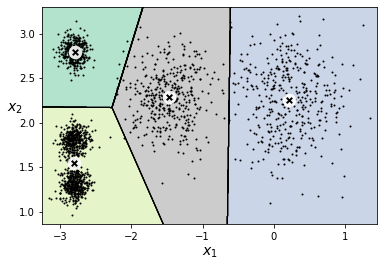

In [61]:
kmeans_4 = KMeans(n_clusters=4)
kmeans_4.fit(X)
plot_decision_boundaries(kmeans_4, X)

#### Not too bad! The bottom two clusters get clustered together, so lets look at Siloutte score, which may produce better results

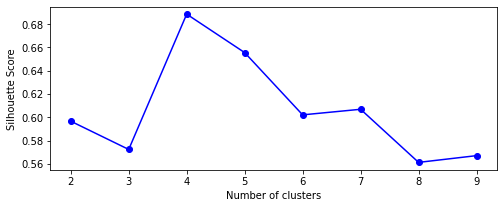

In [66]:
from sklearn.metrics import silhouette_score

s_scores = []
num_clusters = range(2, 10) 
for i in num_clusters:
    cur_kmeans = KMeans(n_clusters=i)
    cur_kmeans.fit(X)
    cur_score = silhouette_score(X, cur_kmeans.labels_)
    s_scores.append(cur_score)

plt.figure(figsize=(8,3))
plt.plot(num_clusters, s_scores, "bo-")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.show()

#### We see high values at 4 and 5, so these are worth considering

#### Lets plot a silhoutte Diagram

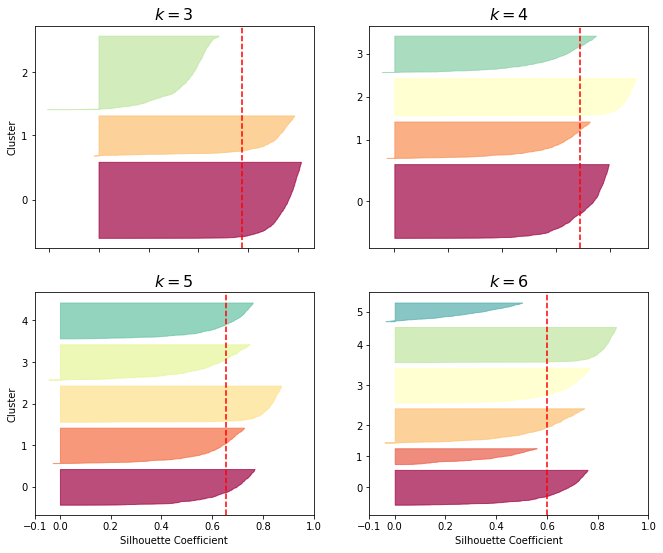

In [70]:
# The code in this cell is obtained from https://github.com/ageron/handson-ml/blob/master/08_dimensionality_reduction.ipynb


from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

#### Here, both 4 and 5 have knives which are close to the dashed line, which is the mean silhoutte coefficient. Knives that are wider are better, and the height represents number of instances. 4 and 5 seem pretty good, since they both have knives that extend beyond the dashed line, but 5 may perhaps be better according to this diagram, as 4 has one knive that has a significanlty bigger height than the others, while 5 has more evenly heighted knives, which means that 4 may have clustered two clusters together, while 5 kept them seperate.